Conda env: test_xarray_3_9

In [1]:
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import random

from datetime import datetime, timedelta
import zarr

In [2]:
folder_path = '/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data' #'/home/jan/Programming/remote/first_CNN_on_radolan_remote/dwd_nc/own_test_data'
file_name_radolan = 'testdata_two_days_2019_01_01-02.zarr'
load_path = os.path.join(folder_path, file_name_radolan)
load_path_dem = '/Users/jan/Programming/geo_data/static/dem_benchmark_dataset_1200_1100.zarr'

print(f'loading from: {load_path}')


loading from: /Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr


In [3]:
num_input_frames = 4
lead_time = 4
pt = num_input_frames + lead_time # how many time steps to include in a sample (i.e. context and target)
# 
# This defines the size of the patches, that are created by coarsen, filter is applies to these patches
py, px = 32, 32 #73, 137 # how many pixels in y and x direction
y_input, x_input = 256, 256
y_input_padding, x_input_padding = 32, 32
threshold_mm_rain_each_pixel = 0.1 # threshold for each pixel filter condition
threshold_percentage_pixels = 0.5


# In the current implementation py and px define the size of the target patches (previously those were the larger input patches)
# length_width_center_even as the same size as py and px, as the filter condition is calculated on the target patches

In [4]:
data = xr.open_dataset(load_path, engine='zarr') # , chunks=None # , chunks=None according to Sebastian more efficient as it avoids dask (default is chunks=1)
# Simply reinstalled environment with numpy pandas xarray zarr jupyter
# Now not the same error as in first_CNN_on_Radolan env for some reason
data = data.squeeze()


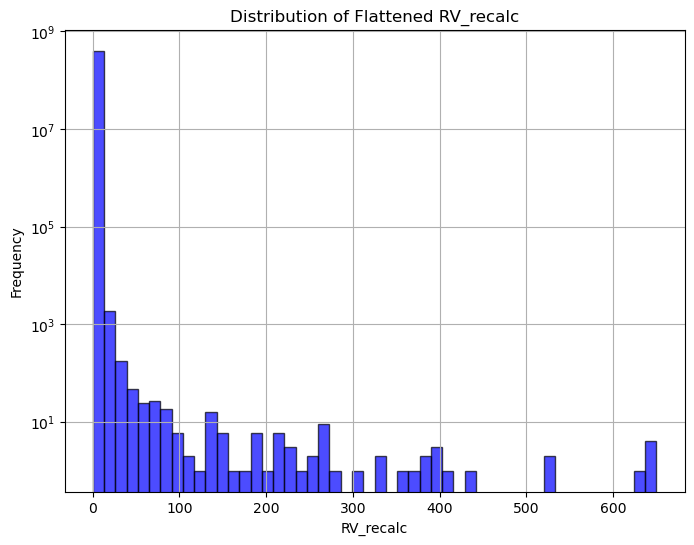

In [5]:


def plot_flattened_distribution(ds, var_name='RV_recalc'):
    # Flatten the data
    data_flat = ds[var_name].values.flatten()

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(data_flat, bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Flattened {var_name}')
    plt.xlabel(var_name)
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    

plot_flattened_distribution(data)

In [6]:
def count_negative_values(ds, var_name='RV_recalc'):
    # Flatten the data and count negative values
    data_flat = ds[var_name].values.flatten()
    negative_count = np.sum(data_flat < 0)
    mini = np.nanmin(data_flat)
    
    return negative_count, mini
negative_count, mini = count_negative_values(data)
print(f'Number of negative values: {negative_count}, min: {mini}')

Number of negative values: 2446583, min: -2.842170943040401e-14


In [7]:
data.min(skipna=True, dim=None).RV_recalc.values

array(-2.84217094e-14)

In [8]:
# Set all negative values of the data to 0
data_min = data.min(skipna=True, dim=None).RV_recalc.values
if data_min < -0.1:
    raise ValueError(f'The min value of the data is {data_min}, which is below the threshold of -0.1')
data_no_neg = data.where(data >= 0, 0) 
# The where function keeps values where the condition is True and replaces the rest (where it's False) with the value specified, in this case 0.
data_no_neg.min(skipna=True, dim=None).RV_recalc.values

array(0.)

In [9]:
    # TODO: Crop the beginning of the data, such that we can always generate inputs from the target indecies

# Cut off the beginning  of the data as the size of the data chunk, that one sample has (input frames + lead time + target)
# as we will 'go back in time' to generate the inputs from the target patches
data_shortened = data.isel(
    time=slice(pt, -1)
)

# partition the data into pt x py x px blocks using coarsen --> construct DatasetCoarsen object
# In this implementation each target corresponds to one patch
coarse = data_shortened.coarsen(
    y = py,
    x = px,
    # time = 1, # TODO: This way we are making patches with 4 subsequent time frames. This way we are only taking a target every 'pt'th time step
    side = "left", # "left" means that the blocks are aligned to the left of the input
    boundary="trim") # boundary="trim" removes the last block if it is too small

# construct a new data set, where the patches are folded into a new dimension
patches = coarse.construct(
    # time = ("time_outer", "time_inner"),
    y = ("y_outer", "y_inner"),
    x = ("x_outer", "x_inner"))
# Replace NaNs with 0s for the filter (we do not have to do this! Makes it less likely for the edge cases to occur in the target.)
# We also have the option to filter for NaNs in the input to completely prohibit edge cases
patches_no_nan = patches.fillna(0)

# --- FILTER ---
# define a threshold for each pixel --> we get a pixel-wise boo
patches_boolean_pixelwise = patches_no_nan > threshold_mm_rain_each_pixel
# We are calculating the percentage of pixels that passed filter (mean of boolean gives percentage of True) 
# --> we are getting rid of the patch dimensions y_inner and x_inner, 
patches_percentage_pixels_passed = patches_boolean_pixelwise.mean(("y_inner", "x_inner")) #, "time_inner"
# Now we are creating a boolean again by comparing the percentage of pixels that exceed the rain threshold to the minimally required 
# percentage of pixels that exceed the rain threshold
# --> valid_patches includes only the y_outer and x_outer, where each pair of indecies represents one patch. Its values are boolean, indicating whether or not the outer indecies correspond to a valid or invalid patch. 
valid_patches_boo = patches_percentage_pixels_passed > threshold_percentage_pixels

# get the outer coordinates for all valid blocks (valid_time, valid_x, valid_y)
# (valid_patches_boo is boolean, np.nonzero returns the indecies of the pixels that are non-zero, thus True)
valid_target_indecies_outer = np.array(np.nonzero(valid_patches_boo.RV_recalc.values)).T


### Split data into training and validation

In [10]:
# Write and test the function on dicts
def split_dict(data, s_ratio_training_data):
    '''
    This randomly splits the training and validation data
    '''
    # Ensure s_ratio_training_data is between 0 and 1
    if not 0 <= s_ratio_training_data <= 1:
        raise ValueError("s_ratio_training_data must be between 0 and 1.")
    
    # Shuffle the dictionary keys
    keys = list(data.keys())
    random.shuffle(keys)
    
    # Calculate the split index
    split_index = int(len(keys) * s_ratio_training_data)
    
    # Create the training and validation dictionaries
    training_data = {key: data[key] for key in keys[:split_index]}
    validation_data = {key: data[key] for key in keys[split_index:]}
    
    return training_data, validation_data


def test_split_dict():
    data = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
    portion = 0.6
    training_data, validation_data = split_dict(data, portion)
    
    total_len = len(training_data) + len(validation_data)
    training_len = len(training_data)
    
    # Check if the sizes of both dictionaries add up to the original
    assert total_len == len(data), "Total entries don't match original dict size"
    
    # Check if the portion of training data is correct (within rounding margin)
    expected_training_len = round(len(data) * portion)
    assert training_len == expected_training_len, f"Training data size is incorrect, expected {expected_training_len}, got {training_len}"
    
    print("Test passed.")

# Run the test
test_split_dict()

Test passed.


In [11]:

def split_group_object(data: xr.core.groupby.DatasetGroupBy, s_ratio_training_data):
    '''
    This randomly splits DatasetGroupBy objects the training and validation data
    '''
    # Ensure s_ratio_training_data is between 0 and 1
    if not 0 <= s_ratio_training_data <= 1:
        raise ValueError("s_ratio_training_data must be between 0 and 1.")
    
    # Shuffle the dictionary keys
    keys = list(data.groups.keys())
    random.shuffle(keys)
    
    # Calculate the split index
    split_index = int(len(keys) * s_ratio_training_data)
    
    # Create the training and validation dictionaries
    training_data = xr.concat([data[key] for key in keys[:split_index]], dim='time')
    validation_data = xr.concat([data[key] for key in keys[split_index:]], dim='time')
    
    return training_data, validation_data

We use resample to split. 
Do not use GroupBy for this! It groups the same days of several years into one group

At the bottom of https://docs.xarray.dev/en/stable/user-guide/groupby.html there are some hints

In [12]:
# TODO: use hours instead of days for splitting for test purposes
# daily_boo_resampled = valid_patches_boo.resample(time='1D')
daily_boo_resampled = valid_patches_boo.resample(time='1h')

In [13]:
train_valid_patches_boo, val_valid_patches_boo = split_group_object(daily_boo_resampled, s_ratio_training_data=0.5)

In [14]:
train_valid_target_indecies_outer = np.array(np.nonzero(train_valid_patches_boo.RV_recalc.values)).T
val_valid_target_indecies_outer = np.array(np.nonzero(val_valid_patches_boo.RV_recalc.values)).T

### Calculate Statistics

Somehow only choose the valid patches, flatten the whole data and calc statistics on that!

In [15]:
# Only select the filtered patches by using the boolean mask (on data that includes NaNs)
only_filtered_data = patches.where(valid_patches_boo, drop=True) # I checked that this actually reduces length of time, y_outer and x_outer
only_filtered_data_log = np.log1p(only_filtered_data)
# Calculate the mean and standard deviation across all dimensions, ignoring NaNs

mean = only_filtered_data.mean(dim=None, skipna=True)
std = only_filtered_data.std(dim=None, skipna=True)

log_mean = only_filtered_data_log.mean(dim=None, skipna=True)
log_std = only_filtered_data_log.std(dim=None, skipna=True)


In [16]:
# Calculate min and max for linspace binning across the whole data:
float(linspace_binning_min = data.min(dim=None, skipna=True).RV_recalc.values)
linspace_binning_max = data.max(dim=None, skipna=True).RV_recalc.values

TypeError: float() takes no keyword arguments

In [ ]:
linspace_binning_min = float( data_no_neg.min(dim=None, skipna=True).RV_recalc.values)
linspace_binning_min

In [ ]:
mean.RV_recalc.values, std.RV_recalc.values, log_mean.RV_recalc.values, log_std.RV_recalc.values

mean_filtered_log_data in jetzigem Skript auf Testdaten: 0.09430744498968124 (hier array(0.32245284, dtype=float32),)
std_filtered_log_data in jetzigem Skript auf Testdaten: 0.20077288150787354 (hier array(0.31162593)))

Was ist anders??? --> vorher wurden nans als 0 gewertet, dadurch ist insb. der kleinere mean zu erklären
Außerdem samplen wir hier völlig anders

##### Nochmal testen mit nan to 0:

In [ ]:
only_filtered_data_nan_to_0 = only_filtered_data_log.fillna(0)

log_mean_nan_to_0 = only_filtered_data_nan_to_0.mean(dim=None)
log_std_nan_to_0 = only_filtered_data_nan_to_0.std(dim=None)

In [ ]:
log_mean_nan_to_0.RV_recalc.values, log_std_nan_to_0.RV_recalc.values

Diese Werte sind schon viel näher an dem was wir im Code beobachten. Durch das andere Samplen ist die bestehende Abweochung allerdings zu erwarten

### Normalize data

In [ ]:
def normalize_data(data, log_mean, log_std):
    '''
    Ln(x+1), then z - normalization
    handles torch.Tensor, np.array and xr.Dataset
    '''
    if isinstance(data, torch.Tensor):
        return (torch.log1p(data) - log_mean) / log_std
    else:
        return (np.log1p(data) - log_mean) / log_std # log1p takes natural logarithm of x + 1, numerically stable

def inverse_normalize_data(data, log_mean, log_std):
    '''
    Assumes ln(x+1), then z - normalization
    handles torch.Tensor, np.array and xr.Dataset
    '''
    if isinstance(data, torch.Tensor):
        return torch.expm1(data * log_std + log_mean)
    else:
        return np.expm1(data * log_std + log_mean)
    


##### Test normalize and inv normalize

In [ ]:
patches_log_normalized = normalize_data(patches, log_mean, log_std)
patches_back_to_normal = inverse_normalize_data(patches_log_normalized, log_mean, log_std)

In [ ]:
close = np.isclose(patches.RV_recalc.values, patches_back_to_normal.RV_recalc.values, equal_nan=True) # relative and absolute tolerance by last to args
all_close = np.all(close)

In [ ]:
all_close

### CONVERT INDECIES TO Coords

In [ ]:
# REWRITE TO CONVERT INDECIES TO coords
def valid_indecies_to_global_center_indecies(data_shortened, valid_target_indecies_outer, px, py, x_input, y_input, x_input_padding, y_input_padding):
    '''
    This functions converts the 'valid_target_indecies_outer' which give the outer indecies with respect to 'patches' to global indecies that refer to 'data_shortened'
    
    The time index of the input and output indecies always refer to the target frame, which the filtering was done on!
    In order to get the input time frames we have to change the time index in the unshortened dataset where the beginning was not clipped!
    
    The patches where the larger input patch exceeds the bounds of data_shortened are dropped! therefore the outputs are shorter than valid_target_indecies_outer
    '''
    
    y_input_padded = y_input + y_input_padding
    x_input_padded = x_input + x_input_padding
    
    valid_target_indecies_global = [] 
    valid_center_indecies_global = []
    valid_input_indecies_global = []
    valid_input_coords = [] # These are defined 
    
    
    num_inputs_exceeding_bounds = 0
    
    for (time, y_outer, x_outer) in valid_target_indecies_outer:
        
        y_global_upper = y_outer * py
        x_global_left = x_outer * px
        
        # Calculate the global indecies / slices for the targets
        # TODO I think this can be removed in future
        slice_y_global = slice(y_global_upper, y_global_upper + py)
        slice_x_global = slice(x_global_left, x_global_left + px)
        target_slices = [time, slice_y_global, slice_x_global]
        
        # Calculate indecies of the patche's center pixels
        center_y_global = y_global_upper + py // 2
        center_x_global = x_global_left + px // 2
        global_center_indecies = [time, center_y_global, center_x_global]
        
        # Calculate the global slices for input
        y_slice_input = slice(center_y_global - (y_input_padded // 2), center_y_global + (y_input_padded // 2))
        x_slice_input = slice(center_x_global - (x_input_padded // 2), center_x_global + (x_input_padded // 2))
        input_slices = [time, y_slice_input, x_slice_input]
        
        # Check if the larger input exceeds size, if not append the patch indecies / slices to the list
        if y_slice_input.start < 0 or y_slice_input.stop >= data_shortened.sizes['y'] or x_slice_input.start < 0 or x_slice_input.stop >= data_shortened.sizes['x']:
            num_inputs_exceeding_bounds += 1
            continue # Skips the rest of the loop if input frame exceeds dataset bounds
                
        # Convert indecies to coordinates
        # TODO: Is there a better way to do this?
        time_datetime = data_shortened.time.isel(time=time).values
        
        y_coords_input = data_shortened.y.isel(y=y_slice_input).values
        x_coords_input = data_shortened.x.isel(x=x_slice_input).values
        
        y_coords_slices_input = slice(y_coords_input[0], y_coords_input[-1])
        x_coords_slices_input = slice(x_coords_input[0], x_coords_input[-1])
        
        input_coords = [time_datetime, y_coords_slices_input, x_coords_slices_input]
    
        
        valid_target_indecies_global.append(target_slices)
        valid_center_indecies_global.append(global_center_indecies)
        valid_input_indecies_global.append(input_slices)
        valid_input_coords.append(input_coords)
        
    print(f'{num_inputs_exceeding_bounds} patches dropped as input exceeded spatial data bounds')    
    return (
        np.array(valid_input_coords),
        np.array(valid_input_indecies_global),
        np.array(valid_target_indecies_global),
        np.array(valid_center_indecies_global))

In [ ]:
valid_input_coords, valid_input_indecies_global, valid_target_indecies_global, valid_center_indecies_global = valid_indecies_to_global_center_indecies(
    data_shortened, valid_target_indecies_outer, px, py, y_input, x_input, x_input_padding, y_input_padding)

In [ ]:
valid_target_indecies_global[0]

##### Load DEM (digital elevation model)

In [ ]:
dem_data = xr.open_dataset(load_path_dem, engine='zarr')

In [ ]:
dem_data.crs, data.crs

Why are the transforms different? This means that the data is not compatible..

In [ ]:
dem_data.transform, data.transform

Check whether Radolan is a subset of DEM

In [ ]:
y_coords_range_radolan = data_shortened.y.isel(y=slice(0,-1)).values
x_coords_range_radolan = data_shortened.x.isel(x=slice(0,-1)).values

dem_range_radolan = dem_data.sel(
    y = y_coords_range_radolan,
    x = x_coords_range_radolan
)
plt.figure()
plt.imshow(dem_range_radolan.dem.values, cmap='viridis')
plt.show()
print('Radolan is within the bounds of DEM')

### Get the frames --> Future get_item function in data loader

In [ ]:
def get_chunk_from_coords(input_coord, data, num_input_frames, lead_time, time_step_data_minutes=5):
    '''
    This function takes in the coordinates 'input_coord' 
        Each input_coord represents one patch that passed the filter.
        The spatial slices in input_coord have the spatial size of the input + the augmentation padding 
        The temporal datetime point gives the time of the target frame (as the filter was applied to the target)
        Therefore to get the inputs we have to go back in time relative to the given time in input_coord (depending on lead time and num_input_frames)
    
    Returns the input and target patches. Both the input and the target patches are in the size of    
    '''

    
    # Make sure this is an int:
    num_input_frames = int(num_input_frames)
    lead_time = int(lead_time)
    
    # extract coordinates / coordinat slices
    time, y_slice, x_slice = input_coord
    
    # TODO: IS LEAD TIME CORRECT? I had to take input 5min * input frame -1 to not choose 4, how about the lead time?
    # Go back in time to get the time slice of the input
    # in oppose to np or list indexing where the last index is not included, the last index is included when taking the datetime slices,
    # therefore num_input_frames - 1!
    time_start = time - np.timedelta64(time_step_data_minutes * (num_input_frames - 1 + lead_time), 'm')
    time_end = time
    
    time_slice = slice(time_start, time_end)
    time_coord_target = time
    
    # Generate input and output data
    spacetime_chunk = data.sel(
        time = time_slice,
        y = y_slice,
        x = x_slice,
    )
    chunk_values = spacetime_chunk.RV_recalc.values
    
    
    return torch.Tensor(chunk_values)

In [ ]:
rand_coord_idx = np.random.randint(0, valid_input_coords.shape[0])

In [ ]:
coord = valid_input_coords[rand_coord_idx]
spacetime_chunk = get_chunk_from_coords(coord, data, num_input_frames, lead_time)


In [ ]:
input_frames_no_augment = spacetime_chunk[0:num_input_frames, :, :]
target_frame_no_augment = spacetime_chunk[-1, :, :]

### Augment the frames

In [ ]:
# Random crop
random_crop = transforms.RandomCrop(size=(64,64))
spacetime_chunk_cropped = random_crop(spacetime_chunk)

In [ ]:
input_frames = spacetime_chunk_cropped[0:num_input_frames, :, :]
target_frame = spacetime_chunk_cropped[-1, :, :]

# Test Stuff

##### Test get_patches_from_coords

In [ ]:
num_frames = input_frames_no_augment.shape[0]  # This should be 4 as per your description

plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
for i in range(num_frames):
    plt.subplot(1, num_frames, i + 1)  # 1 row, num_frames columns, i+1 is the subplot index
    plt.imshow(input_frames_no_augment[i, :, :], cmap='viridis')  # Show the ith frame
    plt.title(f'Frame {i+1}')  # Title for each subplot
    plt.axis('off')  # Hide the axis

plt.suptitle('Input Frames')  # Super title for the entire figure
plt.show()  # Display the plot

NameError: name 'target_frame_no_augment' is not defined

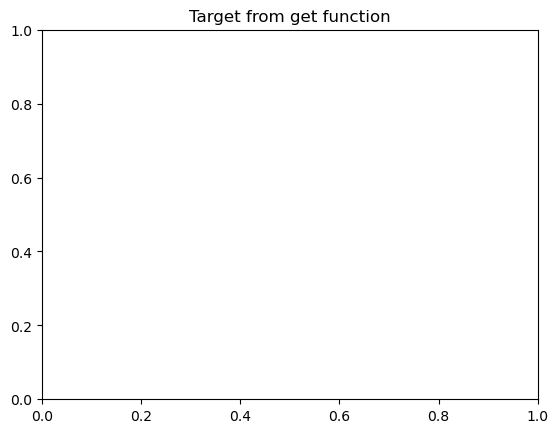

In [17]:
plt.figure()
plt.title('Target from get function')
plt.imshow(target_frame_no_augment, cmap='viridis')

### Test cropped images

In [18]:
num_frames = input_frames.shape[0]  # This should be 4 as per your description

plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
for i in range(num_frames):
    plt.subplot(1, num_frames, i + 1)  # 1 row, num_frames columns, i+1 is the subplot index
    plt.imshow(input_frames[i, :, :], cmap='viridis')  # Show the ith frame
    plt.title(f'Frame {i+1}')  # Title for each subplot
    plt.axis('off')  # Hide the axis

plt.suptitle('Cropped Input Frames')  # Super title for the entire figure
plt.show()  # Display the plot

NameError: name 'input_frames' is not defined

NameError: name 'target_frame' is not defined

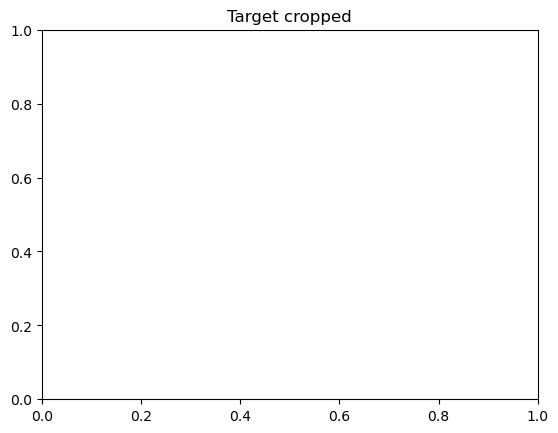

In [19]:
plt.figure()
plt.title('Target cropped')
plt.imshow(target_frame, cmap='viridis')

### Test converting indecies to coors

In [ ]:
time, y_outer, x_outer = sample_coord

y_global_upper = y_outer * py
x_global_left = x_outer * px

# Calculate the global indecies / slices for the targets
slice_y_global = slice(y_global_upper, y_global_upper + py)
slice_x_global = slice(x_global_left, x_global_left + px)
target_slices = [time, slice_y_global, slice_x_global]

# Calculate indecies of the patche's center pixels
center_y_global = y_global_upper + py // 2
center_x_global = x_global_left + px // 2
global_center_indecies = [time, center_y_global, center_x_global]

# Calculate the global slices for input
# TODO: make sure this does not go out of bounds, create NAN padding of some sort in case the input size exceeds the nan bounds
y_slice_input = slice(center_y_global - (y_input // 2), center_y_global + (y_input // 2))
x_slice_input = slice(center_x_global - (x_input // 2), center_x_global + (x_input // 2))
input_slices = [time, y_slice_input, x_slice_input]

# Convert indecies to coordinates
patch = data_shortened.isel(
    time = time,
    y = y_slice_input,
    x = x_slice_input,
)

# Step 1: Extract the coordinate values at the indices
time_value = data_shortened.time.isel(time=time).values
lat_values = data_shortened.y.isel(y=y_slice_input).values
lon_values = data_shortened.x.isel(x=x_slice_input).values

# Step 2: Use these values to select data with sel
patch_from_coords = data_shortened.sel(
    time=time_value,
    y=slice(lat_values[0], lat_values[-1]),
    x=slice(lon_values[0], lon_values[-1]))

In [ ]:
time_value

In [ ]:
lat_values

In [ ]:
sample_block_vals = patch_from_coords.RV_recalc.values.squeeze()
plt.figure()
plt.title("patch_from_coords")
plt.imshow(sample_block_vals, cmap='viridis')

# group by day xarray --> group by day to split in training and validation

In [ ]:
sample_block_vals = patch.RV_recalc.values.squeeze()
plt.figure()
plt.title("patch_from_coords")
plt.imshow(sample_block_vals, cmap='viridis')

# group by day xarray --> group by day to split in training and validation

### Try to understand data structure


In [ ]:
data_shortened

##### Converting between np indecies to coords

In [ ]:
time_value = data_shortened.time.isel(time=500).values
y_value = data_shortened.y.isel(y=600).values
x_value = data_shortened.x.isel(x=600).values

In [ ]:
time_value, y_value, x_value

In [ ]:

time_value = data_shortened.time.sel(time=time_value, method='nearest').values
y_value = data_shortened.y.sel(y=y_value, method='nearest').values
x_value = data_shortened.x.sel(x=x_value, method='nearest').values
time_value, y_value, x_value

In [ ]:
data_shortened.sel(
    time = time_value,
    y = y_value,
    x = x_value,
).RV_recalc.values

In [ ]:
data_shortened.isel(
    time = 500,
    y = 600,
    x = 600,
).RV_recalc.values

### Test Filter

In [ ]:
# Test filter on all samples
for i in range(valid_target_indecies_outer.shape[0]):
# i = 1
    coord = valid_target_indecies_outer[i, :]
    block = patches.isel(
        time = coord[0],
        y_outer = coord[1],
        x_outer = coord[2])
    block = block.squeeze()
    block_vals = block.RV_recalc.values
    
    pixel_over_thres_ratio = (block_vals > threshold_mm_rain_each_pixel).sum() / len(sample_block_vals)
    if pixel_over_thres_ratio < threshold_percentage_pixels:
        print(f'Ratio is {pixel_over_thres_ratio} which is below {threshold_percentage_pixels}')

In [ ]:
plt.figure()
plt.imshow(data_shortened.isel(time=23).RV_recalc.values)